# GDAL 实例

## 一、基础文件流读写

In [3]:
from osgeo import gdal
from osgeo import gdal_array
import matplotlib.pyplot as plt
import numpy as np
import os

### 读写

In [30]:
def read_geotiffAll(filename):
    # 读取整个文件，包括元数据、投影、仿射变换参数
    # driver = gdal.GetDriverByName('GTiff')# 注册驱动
    ds = gdal.Open(filename)
    # 获取元数据、投影、仿射变换参数
    # print(ds.GetMetadata())
    # print(ds.GetProjection())
    # print(ds.GetGeoTransform())
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray()
    return data

def read_geotiff_by_window(filename, xoff, yoff, xsize, ysize):
    # 读取指定窗口的数据，不包括元数据、投影、仿射变换参数
    ds = gdal.Open(filename)
    array = ds.ReadAsArray(xoff, yoff, xsize, ysize) # 读取矩阵数据
    return array

def read_geotiff_AsArray(filename):
    # 返回的是一个numpy数组，不包含元数据、投影、仿射变换参数
    data = gdal_array.LoadFile(filename)
    return data

def writeTiff(im_data, im_geotrans, im_proj, path):
    """
    Save image data to a GeoTIFF file.

    Parameters:
    - im_data: numpy array, image data
    - im_geotrans: tuple, geotransform parameters
    - im_proj: str, projection information
    - path: str, output file path
    """
    # Determine the data type
    # print(im_data.shape)
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    elif 'float32' in im_data.dtype.name or 'float64' in im_data.dtype.name:
        datatype = gdal.GDT_Float32
    else:
        raise ValueError("Unsupported data type")

    # Check if the data is multi-band
    if len(im_data.shape) >= 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_data = np.expand_dims(im_data, axis=0)
        # print(im_data.shape)
        im_bands, im_height, im_width = im_data.shape
    
    # print(im_bands, im_height, im_width)
    # Create the file
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    
    if dataset is None:
        raise IOError(f"Failed to create file: {path}")

    try:
        dataset.SetGeoTransform(im_geotrans)  # Write geotransform parameters
        dataset.SetProjection(im_proj)  # Write projection
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
    finally:
        dataset = None  # Ensure the dataset is closed


### 优化写入

In [ ]:
# 优化写入GeoTIFF文件，使用块写入
def writeTiff_Advance(im_data, im_geotrans, im_proj, path, block_size=(256, 256)):
    """
    Save image data to a GeoTIFF file with performance optimization.

    Parameters:
    - im_data: numpy array, image data
    - im_geotrans: tuple, geotransform parameters
    - im_proj: str, projection information
    - path: str, output file path
    - block_size: tuple, block size for writing data (width, height)
    """
    # Determine the data type
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    elif 'float32' in im_data.dtype.name or 'float64' in im_data.dtype.name:
        datatype = gdal.GDT_Float32
    else:
        raise ValueError("Unsupported data type")

    # Check if the data is multi-band
    if len(im_data.shape) >= 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_data = np.expand_dims(im_data, axis=0)
        im_bands, im_height, im_width = im_data.shape

    # Create the file
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    if dataset is None:
        raise IOError(f"Failed to create file: {path}")

    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)

    # Write data in blocks
    for band_index in range(im_bands):
        band = dataset.GetRasterBand(band_index + 1)
        band.SetNoDataValue(0)  # Set no data value if needed
        for i in range(0, im_height, block_size[1]):
            for j in range(0, im_width, block_size[0]):
                xoff = j
                yoff = i
                width = min(block_size[0], im_width - xoff)
                height = min(block_size[1], im_height - yoff)
                data = im_data[band_index, i:i+height, j:j+width]
                band.WriteArray(data, xoff, yoff)

    dataset = None  # Ensure the dataset is closed

### 影像波段合成与分离

In [16]:
from tqdm import tqdm
# 归一化显示
def scaleMinMax(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
# 标准差值显示
def scaleMeanStd(x):
    return ((x - (np.nanmean(x)-np.nanstd(x)*2))/((np.nanmean(x)+np.nanstd(x)*2) - (np.nanmean(x)-np.nanstd(x)*2)))
# 线形拉伸
def scaleLinear(x, pecentage=2):
    return((x - np.nanpercentile(x, pecentage))/(np.nanpercentile(x, (100-pecentage)) - np.nanpercentile(x,pecentage)))
# 影像显示 
def show_geotiff(filename, mode: int, bands:tuple[int,int,int])->None:
    """
    可视化影像

    params:
    - filename: str, geotiff文件路径
    - mode: int, 显示模式, 1:归一化显示, 2:标准差显示, 3:线形拉伸
    - bands: tuple[int,int,int], 波段顺序
    """
    ds = gdal.Open(filename)
    r = ds.GetRasterBand(bands[0]).ReadAsArray()
    g = ds.GetRasterBand(bands[1]).ReadAsArray()
    b = ds.GetRasterBand(bands[2]).ReadAsArray()
    if mode == 1:
        r = (scaleMinMax(r)*255).astype(np.uint8)
        g = (scaleMinMax(g)*255).astype(np.uint8)
        b = (scaleMinMax(b)*255).astype(np.uint8)
    elif mode == 2:
        r = (scaleMeanStd(r)*255).astype(np.uint8)
        g = (scaleMeanStd(g)*255).astype(np.uint8)
        b = (scaleMeanStd(b)*255).astype(np.uint8)
    elif mode == 3:
        r = (scaleLinear(r)*255).astype(np.uint8)
        g = (scaleLinear(g)*255).astype(np.uint8)
        b = (scaleLinear(b)*255).astype(np.uint8)
    rgb = np.dstack((r,g,b))
    plt.imshow(rgb)
    plt.colorbar()
    plt.show()
# 波段合成
def MultiBandsCompose(inputPath, outputPath, filename, strfilter='.tif'):
  files = os.listdir(inputPath)
  files = list(filter(lambda file: file.endswith(strfilter), files))
  N = len(files)
  # 判断输入文件夹是否为空
  if N == 0:
    print("No file in the input path!")
    return
  gdal.AllRegister()
  projection = None
  gt = None
  row = -9999
  col = -9999
  dtypes = []
  # 判断输入文件是否有不同的大小或投影
  for file in files:
    ds = gdal.Open(os.path.join(inputPath, file))
    band = ds.GetRasterBand(1)
    dtypes.append(band.DataType)
    if row == -9999 or col == -9999:
      row = ds.RasterYSize
      col = ds.RasterXSize
      projection = ds.GetProjection()
      gt = ds.GetGeoTransform()
    else:
      if row != ds.RasterYSize or col != ds.RasterXSize:
        print("The size of the input files is not the same!")
        return
      elif projection != ds.GetProjection() or gt != ds.GetGeoTransform():
        print("The projection or geotransform of the input files is not the same!")
        return
      else:
        pass
  driver = gdal.GetDriverByName('GTiff')
  dMax = max(dtypes)# 设置输出文件的数据类型
  # 估算文件大小，判定是否创建BIGTIFF
  GDT_dict = dict([
    (1,8),
    (2,16),
    (3,16),
    (4,32),
    (5,32),
    (6,32),
    (7,64),
    (8,16),
    (9,32),
    (10,32),
    (11,64)
  ])
  outputSize = GDT_dict[dMax]*col*row/8/1024/1024*N
  bigTiffFlag = 'YES' if outputSize >= 4 else 'NO'
  outds = driver.Create(os.path.join(outputPath, filename), col, row, 
                        N, dMax, options = ["COMPRESS=LZW", f"BIGTIFF={bigTiffFlag}"])
  outds.SetProjection(projection)
  outds.SetGeoTransform(gt)
  # 逐个波段写入
  pbar = tqdm(files, desc='Composing', colour='green')
  for file in pbar:
    pbar.set_description('正在处理{}'.format(file))
    data = gdal_array.LoadFile(os.path.join(inputPath, file))
    i  = files.index(file)
    outband = outds.GetRasterBand(i+1)
    outband.WriteArray(data)
  print("Composing Finished!")
  outds = None
  
# inputPath = r'F:\esriContest\muli_sr\2007'
# outputPath = r'F:\esriContest\muli_sr\2007'
# filename = 'RGB.tif'
# MultiBandsCompose(inputPath, outputPath, filename)

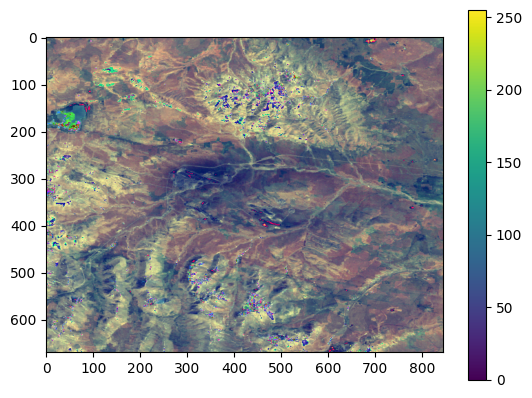

In [18]:
show_geotiff(r'F:\esriContest\muli_sr\2007\RGB.tif', mode=2, bands=(3,2,1))

In [35]:
# 波段分离
def bandsSplit(inputPath, outputpath, index=1, bands:tuple=None, batch=False)->None:
    """
    params:
    - inputPath: str, 输入文件路径
    - outputpath: str, batch为false时为输出文件名, batch为true时为输出文件夹路径
    - index: int, 波段索引
    - bands: tuple, 波段索引列表
    - batch: bool, 是否批量处理
    """
    ds = gdal.Open(inputPath)
    if batch:
        if bands is None:
            raise ValueError("bands must be provided when batch is True")
        for band_index in bands:
            band = ds.GetRasterBand(band_index)
            data = band.ReadAsArray()
            output_file = f"{outputpath}\split_{band_index}.tif"  # 为每个波段创建不同的输出文件
            writeTiff(data, ds.GetGeoTransform(), ds.GetProjection(), output_file)
    else:
        if bands is not None:
            raise ValueError("bands should not be provided when batch is False")
        band = ds.GetRasterBand(index)
        data = band.ReadAsArray()
        writeTiff(data, ds.GetGeoTransform(), ds.GetProjection(), outputpath)

# 示例调用
# bandsSplit(r'F:\esriContest\muli_sr\2007\RGB.tif', r'F:\esriContest\muli_sr\2007\B1_split.tif', 1, batch=False)
# print("Done!")

# 批量处理示例调用
# bandsSplit(r'F:\esriContest\muli_sr\2007\RGB.tif', r'F:\esriContest\muli_sr\2007', bands=(1, 2), batch=True)
# print("Batch Done!")

Batch Done!


## 二、影像处理

### 重采样

In [15]:
# 重采样
ds = gdal.Open(r'F:\esriContest\muli_sr\2007\split_1.tif')
print(ds.GetGeoTransform())

desRsample = gdal.Warp(r'F:\esriContest\muli_sr\2007\split_1_resample.tif', ds, xRes=0.01, yRes=0.01, resampleAlg=gdal.GRA_Bilinear)
print(desRsample.GetGeoTransform())

(99.05003985758668, 0.00026949458523585647, 0.0, 38.216757637711574, 0.0, -0.00026949458523585647)
(99.05003985758668, 0.01, 0.0, 38.216757637711574, 0.0, -0.01)


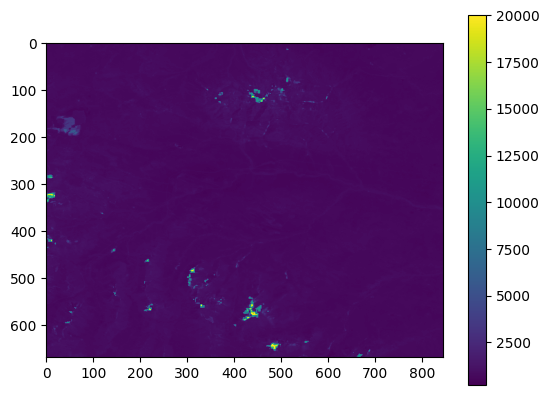

In [17]:
arrayds = ds.GetRasterBand(1).ReadAsArray()
plt.imshow(arrayds)
plt.colorbar()

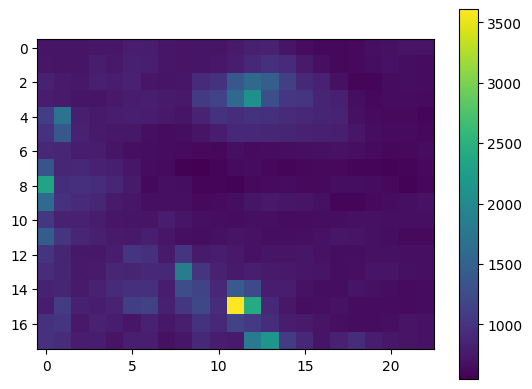

In [16]:
arrayRe = desRsample.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(arrayRe)
plt.colorbar()
plt.show()

In [18]:
desRsample = None
arrayds = None
arrayRe = None

### 投影转换

In [12]:
# 重投影
desReproject = gdal.Warp(r'F:\esriContest\muli_sr\2007\split_1_reproject.tif', ds, dstSRS='EPSG:3857')
print(desReproject.GetSpatialRef())

PROJCS["WGS 84 / Pseudo-Mercator",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Mercator_1SP"],
    PARAMETER["central_meridian",0],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],
    AUTHORITY["EPSG","3857"]]


In [22]:
desReproject = None

### 裁剪与镶嵌

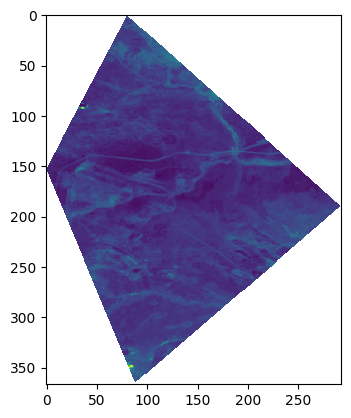

In [20]:
# 裁剪
desClip = gdal.Warp(r'F:\esriContest\muli_sr\2007\split_1_clip.tif', ds, 
                    cutlineDSName=r'F:\esriContest\muli_sr\2007\roi.shp', 
                    cropToCutline=True, dstNodata = np.nan)
cliparray = desClip.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(cliparray)
plt.show()

In [21]:
desClip = None
cliparray = None

仿射矩阵：

(99.05003985758668, 0.00026949458523585647, 0.0, 38.216757637711574, 0.0, -0.00026949458523585647)

六个参数分别对应：

左上角x坐标， 水平分辨率，旋转参数，左上角y坐标，旋转参数，-垂直分辨率

图像行列号和地理坐标之间的变换，变换关系如下：

Xgeo = GeoTransform[0] + Xpixel*GeoTransform[1] + Ypixel*GeoTransform[2]

Ygeo = GeoTransform[3] + Xpixel*GeoTransform[4] + Ypixel*GeoTransform[5]

In [43]:
# 投影坐标系裁剪为小块
def clip2pieces4proj(inputPath, outputPath, xDiv, yDiv):
  ds = gdal.Open(inputPath)
  gt = ds.GetGeoTransform()
  print(gt)
  xmin = gt[0]
  ymax = gt[3]
  revolusion = gt[1]
  xlen = ds.RasterXSize*revolusion
  ylen = ds.RasterYSize*revolusion
  xBlockSize = xlen//xDiv
  yBlockSize = ylen//yDiv
  xSteps = [xmin + i*xBlockSize for i in range(xDiv+1)]
  ySteps = [ymax - i*yBlockSize for i in range(yDiv+1)]
  for i in range(xDiv):
      for j in range(yDiv):
        xmin = xSteps[i]
        xmax = xSteps[i + 1]
        ymax = ySteps[j]
        ymin = ySteps[j + 1]
        print(xmin, xmax, ymin, ymax)
        filename = f"{outputPath}\clip_{i}_{j}.tif"
        try:
          result = gdal.Warp(filename, ds,
                             outputBounds=(xmin, ymin, xmax, ymax),
                             dstNodata=-9999)
          # translate实现相同功能
          # result = gdal.Translate(filename, ds, projWin=[xmin, ymax, xmax, ymin])
          if result is None:
            print(f"Failed to save {filename}")
          else:
            print(f'{filename} has been saved!')
        except Exception as e:
          print(f"Error saving {filename}: {e}")
  ds = None

In [1]:
# 地理坐标系裁剪为小块
def clip2pieces4geo(inputPath, outputPath, xDiv, yDiv):
    ds = gdal.Open(inputPath)
    if ds is None:
        print(f"Failed to open {inputPath}")
        return
    gt = ds.GetGeoTransform()
    # print(gt)
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    xBlockSize = cols // xDiv
    yBlockSize = rows // yDiv
    xSteps = [gt[0] + xBlockSize * gt[1] * i for i in range(xDiv+1)]
    ySteps = [gt[3] + yBlockSize * gt[5] * i for i in range(yDiv+1)]
    # print(xSteps, ySteps)
    for i in range(xDiv):
        for j in range(yDiv):
            xmin = xSteps[i]
            xmax = xSteps[i+1]
            ymax = ySteps[j]
            ymin = ySteps[j+1]
            filename = f"{outputPath}\\clip_{i}_{j}.tif"
            try:
                result = gdal.Warp(filename, ds,
                                   outputBounds=(xmin, ymin, xmax, ymax),
                                   dstNodata=np.nan)
                # result = gdal.Translate(filename, ds, projWin=[xmin, ymax, xmax, ymin])
                if result is None:
                    print(f"Failed to save {filename}")
                    print(f"GDAL Error: {gdal.GetLastErrorMsg()}")
                else:
                    print(f'{filename} has been saved!')
            except Exception as e:
                print(f"Error saving {filename}: {e}")
    ds = None

In [6]:
# 调用
clip2pieces4geo(r'F:\esriContest\muli_sr\2007\split_1.tif', r'F:\esriContest\muli_sr\2007', 3, 3)

F:\esriContest\muli_sr\2007\clip_0_0.tif has been saved!
F:\esriContest\muli_sr\2007\clip_0_1.tif has been saved!
F:\esriContest\muli_sr\2007\clip_0_2.tif has been saved!
F:\esriContest\muli_sr\2007\clip_1_0.tif has been saved!
F:\esriContest\muli_sr\2007\clip_1_1.tif has been saved!
F:\esriContest\muli_sr\2007\clip_1_2.tif has been saved!
F:\esriContest\muli_sr\2007\clip_2_0.tif has been saved!
F:\esriContest\muli_sr\2007\clip_2_1.tif has been saved!
F:\esriContest\muli_sr\2007\clip_2_2.tif has been saved!


In [14]:
# 镶嵌
import glob

piecesPath = r"F:\esriContest\muli_sr\2007\pieces\clip_[0-9]_[0-9].tif"
piecesList = glob.glob(piecesPath)
print(piecesList)

['F:\\esriContest\\muli_sr\\2007\\pieces\\clip_0_0.tif', 'F:\\esriContest\\muli_sr\\2007\\pieces\\clip_0_1.tif', 'F:\\esriContest\\muli_sr\\2007\\pieces\\clip_0_2.tif', 'F:\\esriContest\\muli_sr\\2007\\pieces\\clip_1_0.tif', 'F:\\esriContest\\muli_sr\\2007\\pieces\\clip_1_1.tif', 'F:\\esriContest\\muli_sr\\2007\\pieces\\clip_1_2.tif', 'F:\\esriContest\\muli_sr\\2007\\pieces\\clip_2_0.tif', 'F:\\esriContest\\muli_sr\\2007\\pieces\\clip_2_1.tif', 'F:\\esriContest\\muli_sr\\2007\\pieces\\clip_2_2.tif']


In [20]:
# 方法一：使用 gdal_merge.py 结合 subprocess 模块
import subprocess

outputPath = "F:\\esriContest\\muli_sr\\2007\\merge.tif"
cmd = f"gdal_merge.py -o {outputPath}"

# 使用 subprocess 运行命令并捕获输出
try:
    # 使用 subprocess.run 并捕获输出
    result = subprocess.run(
        cmd.split()+piecesList,
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True  # 使用 text=True 来处理输出为文本模式
    )
    # 检查命令是否成功运行
    if result.returncode == 0:
        print("命令成功运行")
        print("输出结果：", result.stdout)
    else:
        print("命令运行失败")
        print("错误信息：", result.stderr)
except Exception as e:
    print("运行命令时发生错误：", e)

# 检查输出文件是否存在
if os.path.exists(outputPath):
    print(f"输出文件已生成：{outputPath}")
else:
    print(f"输出文件未生成：{outputPath}")

命令成功运行
输出结果： 0...10...20...30...40...50...60...70...80...90...100 - done.

输出文件已生成：F:\esriContest\muli_sr\2007\merge.tif


In [21]:
# 方法二：使用gdal.BuildVRT和gdal.Translate
result = None

vrt = gdal.BuildVRT(r'F:\esriContest\muli_sr\2007\merge.vrt', piecesList)
gdal.Translate(r"F:\\esriContest\\muli_sr\\2007\\mergeBYvrt.tif", vrt)

vrt = None